<a href="https://colab.research.google.com/github/strohcj/era-aware-defect-forecasting/blob/main/Colab_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# ✅ Colab-safe minimal stack: keep NumPy>=2 to avoid JAX/OpenCV conflicts
import sys, subprocess, pkgutil, importlib

def pipi(*args):
    return subprocess.check_call([sys.executable, "-m", "pip", *args])

# 1) Make sure pip itself is current
pipi("install", "--quiet", "--upgrade", "pip")

# 2) Pin versions that play well with NumPy>=2
#    pandas 2.2.2 works with NumPy 2.x; matplotlib 3.8.x is safe; PyTorch CPU pinned.
pipi("install", "--quiet",
     "numpy>=2.0,<2.3",
     "pandas==2.2.2",
     "matplotlib==3.8.4")

# 3) PyTorch CPU wheels (no CUDA) – avoids extra deps
pipi("install", "--quiet",
     "torch==2.3.1",
     "torchvision==0.18.1",
     "--index-url", "https://download.pytorch.org/whl/cpu")

# 4) Show what we ended up with
import numpy as np, pandas as pd, matplotlib, torch
print("NUMPY  :", np.__version__)
print("PANDAS :", pd.__version__)
print("MPL    :", matplotlib.__version__)
print("TORCH  :", torch.__version__)


NUMPY  : 2.0.2
PANDAS : 2.2.2
MPL    : 3.8.4
TORCH  : 2.3.1+cpu


In [14]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
rng = np.random.default_rng(7)
torch.manual_seed(7)

In [15]:
import pandas as pd

CANDIDATES = [
    # 1) raw GitHub (best)
    "https://raw.githubusercontent.com/strohcj/era-aware-defect-forecasting/main/data/synthetic/biweekly_panel.csv",
    # 2) blob fallback
    "https://github.com/strohcj/era-aware-defect-forecasting/blob/main/data/synthetic/biweekly_panel.csv?raw=1",
    # 3) local path (if you git clone the repo into the working dir)
    "./data/synthetic/biweekly_panel.csv",
]

df = None
last_err = None
for url in CANDIDATES:
    try:
        print(f"Trying: {url}")
        df = pd.read_csv(url, parse_dates=["BiweekEnd"], low_memory=False)
        print("Loaded OK ✅")
        break
    except Exception as e:
        print(f"Failed: {e}")
        last_err = e

if df is None:
    raise RuntimeError(f"Could not load the CSV from any candidate. Last error: {last_err}")

df.head()

Trying: https://raw.githubusercontent.com/strohcj/era-aware-defect-forecasting/main/data/synthetic/biweekly_panel.csv
Loaded OK ✅


,BiweekEnd,ReleaseWindowID,y_defects,ActiveDevelopers
0,2001-01-15,1,19,7
1,2001-01-29,1,21,7
2,2001-02-12,1,20,7
3,2001-02-26,1,16,5
4,2001-03-12,1,19,6


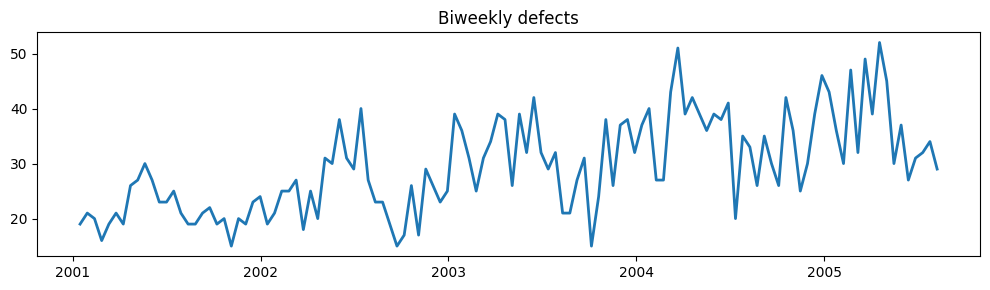

In [16]:
df = df.sort_values("BiweekEnd")
plt.figure(figsize=(10,3))
plt.plot(df["BiweekEnd"], df["y_defects"], lw=2)
plt.title("Biweekly defects")
plt.tight_layout(); plt.show()

In [17]:
# moving average baseline
# y: your target series as a 1D numpy array (e.g., from df["y_defects"].to_numpy(float))

import numpy as np
import torch, torch.nn as nn

y = df["y_defects"].to_numpy(float)
ma3 = pd.Series(y).rolling(3,min_periods=1).mean().to_numpy()

# rollup to next release window if available
if "ReleaseWindowID" in df.columns:
    rel = df.groupby("ReleaseWindowID", as_index=False).agg(
        y_true=("y_defects","sum"),
        y_ma3 =("y_defects",lambda s: pd.Series(s).rolling(3,min_periods=1).mean().sum())
    )
    display(rel.head())
else:
    print("No ReleaseWindowID in CSV; skipping release-level rollup.")

,ReleaseWindowID,y_true,y_ma3
0,1,511,511.000000
1,2,593,596.166667
2,3,723,731.166667
3,4,843,837.333333
4,5,867,865.666667


Epoch 20/60  |  train MAE=6.868  valid MAE=8.329
Epoch 40/60  |  train MAE=5.784  valid MAE=7.598
Epoch 60/60  |  train MAE=5.334  valid MAE=7.225


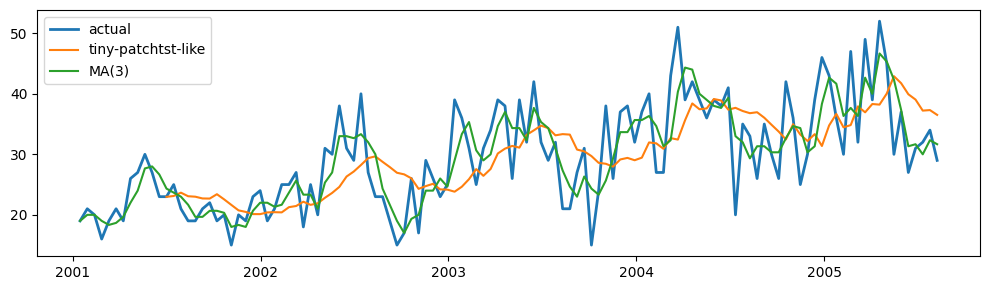

In [18]:
# y: your target series as a 1D numpy array (e.g., from df["y_defects"].to_numpy(float))# Build sliding windows for one-step-ahead
# Build windows once
def make_windows(a, L=12):
    X, y_next = [], []
    for i in range(L, len(a)):
        X.append(a[i-L:i])
        y_next.append(a[i])              # one-step-ahead target
    X = torch.tensor(np.array(X), dtype=torch.float32)   # [N, L]
    y_next = torch.tensor(np.array(y_next), dtype=torch.float32)  # [N]
    return X, y_next

L = 12
X, y_next = make_windows(y, L=L)
split = int(0.8 * len(X))
Xtr, ytr = X[:split], y_next[:split]
Xva, yva = X[split:], y_next[split:]

class TinyPatchTST(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.conv = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*L, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):      # x: [B, L]
        x = x.unsqueeze(1)     # [B, 1, L]
        x = self.relu(self.conv(x))  # [B, 16, L]
        return self.head(x).squeeze(-1)  # [B]

model = TinyPatchTST(L)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

for epoch in range(60):
    model.train()
    opt.zero_grad()
    pred = model(Xtr)
    loss = loss_fn(pred, ytr)
    loss.backward()
    opt.step()
    if (epoch+1) % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_mae = loss_fn(model(Xva), yva).item()
        print(f"Epoch {epoch+1}/60  |  train MAE={loss.item():.3f}  valid MAE={val_mae:.3f}")



# ... train your model ...

# Vectorized one-step-ahead predictions for ALL windows:
model.eval()
with torch.no_grad():
    preds = model(X).cpu().numpy()  # [N]

yhat = np.full(len(y), np.nan, dtype=float)
yhat[L:] = preds                    # first L points have no prediction

# Optional: MA(3) baseline for comparison
import pandas as pd, matplotlib.pyplot as plt
ma3 = pd.Series(y).rolling(3, min_periods=1).mean().to_numpy()

df["y_hat_tiny"] = yhat
df["y_ma3"] = ma3

plt.figure(figsize=(10,3))
plt.plot(df["BiweekEnd"], df["y_defects"], label="actual", lw=2)
plt.plot(df["BiweekEnd"], df["y_hat_tiny"], label="tiny-patchtst-like")
plt.plot(df["BiweekEnd"], df["y_ma3"], label="MA(3)")
plt.legend(); plt.tight_layout(); plt.show()

In [19]:
# Summary
valid = df.iloc[split+L:].copy()
mae_ma3  = np.nanmean(np.abs(valid["y_defects"] - ma3[split+L:]))
mae_tiny = np.nanmean(np.abs(valid["y_defects"] - valid["y_hat_tiny"]))
print(f"MAE  MA(3): {mae_ma3:.2f} | Tiny-PatchTST-like: {mae_tiny:.2f}")

MAE  MA(3): 4.48 | Tiny-PatchTST-like: 7.22
